In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [23]:
def getMiscDict(path):
    dirList = path.split('\\')
    syncType = dirList[len(dirList) - 7]
    memoryStorage = dirList[len(dirList) - 6]
    baseline = dirList[len(dirList) -5]
    testSpreadsheet = dirList[len(dirList) - 4]
    run = int(dirList[len(dirList) - 3].split('-')[1])
    rows = int(dirList[len(dirList) - 2].split('-')[1])
    return {'Sync/Async':syncType, 'Memory Storage':memoryStorage, 'Baseline':baseline,
            'Test Spreadsheet':testSpreadsheet, 'Run':run, 'Rows':rows}

def getMetrics(path):
    """
    Takes in a path string to a .stat file and returns a Pandas DataFrame of the file's contents
    """
    reportsFile = open(path, 'r')
    dataDict = {}
    dataDict = getMiscDict(path)
    for line in reportsFile:
        if ': ' in line:
            metric, value = line.split(": ")
            if metric not in dataDict:
                dataDict[metric] = []
            try:
                dataDict[metric].append(int(value))
            except ValueError:
                dataDict[metric].append(float(value))
            except:
                dataDict[metric].append(value)
    reportsFile.close
    return pd.DataFrame(dataDict)


def getAllMetrics(basePath, miscDict={'sync type':'', 'mem type':'', 'impl':'', 'test':'', 'run':0}):
    """
    Takes in a file path and searches all of its subdirectories for .stat files and returns all of
    their contents in a Pandas DataFrame
    """
    data = pd.DataFrame()
    for file in os.listdir(basePath):
        filePath = os.path.join(basePath, file)
        if os.path.isdir(filePath):
            data = data.append(getAllMetrics(filePath))
        elif file == "core.stat":
            data = data.append(getMetrics(filePath))
    
    return data


def summarizeTest(testData, x=["Number of cells to update"], y=['Total test time (ms)', 'Total time of getting dependents (ms)']):
    """
    Plots the test results given in testData on the given x and y values
    """
    testData = testData.groupby(x).mean()
    ax = testData.plot.bar(y=y, subplots=True, figsize=(12,8))
    for pltIndex in np.arange(len(y)):
        ax[pltIndex].set_ylabel('Time in ms')

In [87]:
# Test result path (CHANGE)
testPath = "C:\\Users\\jonat\\Documents\\Dataspread\\FormulaCompressionTest\\Chris\\FormulaCompressionTesting\\testing\\reports"

pd.set_option('max_rows', 90)
testData = getAllMetrics(testPath)
testData = testData.groupby(['Sync/Async', 'Memory Storage', 'Baseline', 'Test Spreadsheet', 'Rows']).median()
testData = testData.reset_index(level='Rows')
testData = pd.pivot_table(testData, index='Rows', columns=testData.index)['Total time to update cells (ms)']
testData

,"(async, DB, Async, RunningTotalSlow)","(async, DB, Comp, RunningTotalSlow)","(async, DB, PGImpl, RunningTotalSlow)","(sync, DB, Async, RunningTotalSlow)","(sync, DB, Comp, RunningTotalSlow)","(sync, DB, PGImpl, RunningTotalSlow)"
Rows,,,,,,
5000,39,39,103,8433,7771,9000
10000,35,40,176,18897,17899,17098
15000,34,36,276,40296,35078,30027
20000,38,39,350,65340,64565,60011
25000,35,37,416,114402,118675,105576


Text(0.5, 1.0, 'Sync RunningTotalSlow Plots')

<Figure size 864x576 with 0 Axes>

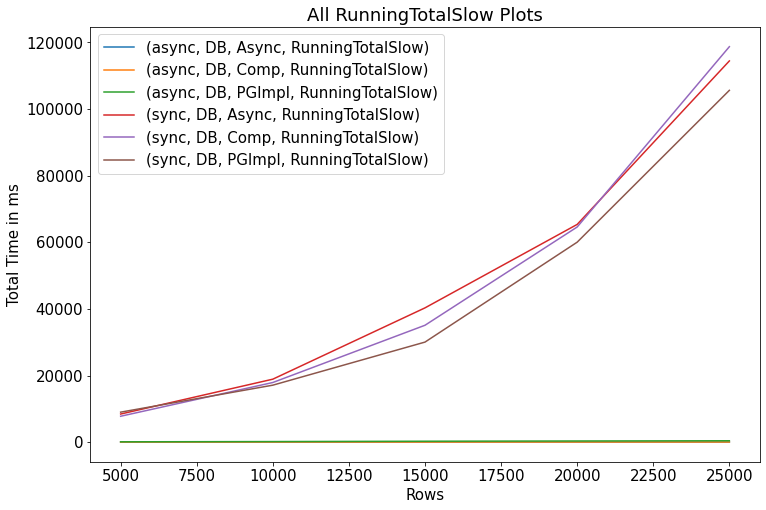

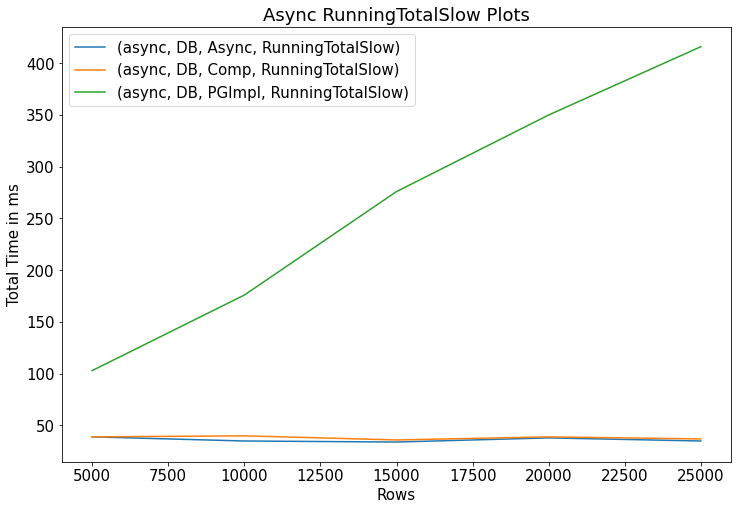

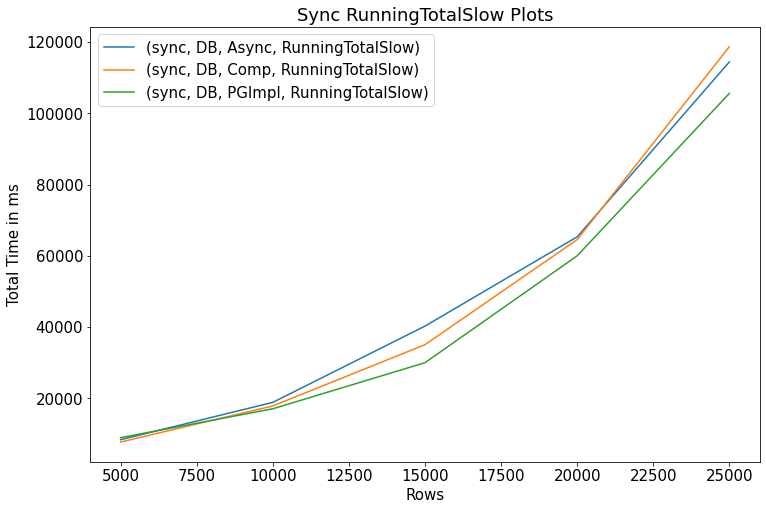

In [88]:
plt.figure()
plt.rcParams.update({'font.size': 15, 'figure.figsize': (12,8)})
mainplot = testData.plot.line()
mainplot.set_ylabel('Total Time in ms')
mainplot.set_title('All RunningTotalSlow Plots')


asyncData = testData.iloc[:, [0,1,2]]
syncData = testData.iloc[:, [3,4,5]]

asyncplot = asyncData.plot.line()
asyncplot.set_ylabel('Total Time in ms')
asyncplot.set_title('Async RunningTotalSlow Plots')
syncplot = syncData.plot.line()
syncplot.set_ylabel('Total Time in ms')
syncplot.set_title('Sync RunningTotalSlow Plots')